In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [31]:
dataset_dir = "E:\AICTE\Garbage classification\Garbage classification"


In [32]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

In [39]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.25,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.
Using 1896 files for training.


In [40]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.25,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.
Using 631 files for validation.


In [41]:
val_classes = test_ds.class_names
val_classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [42]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [43]:
val_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

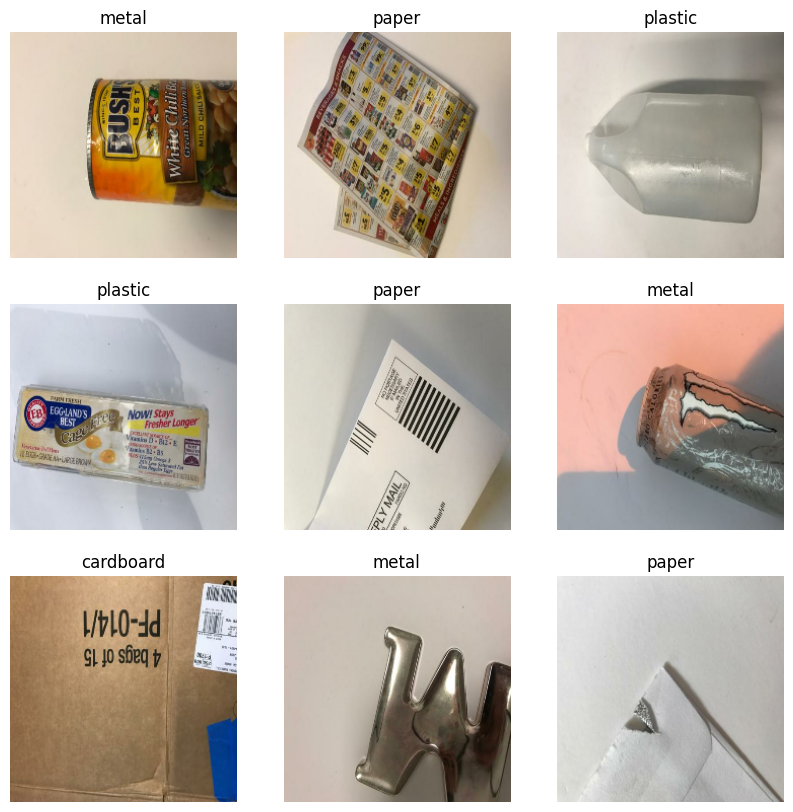

In [44]:
plt.figure(figsize=(10, 10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(val_classes[labels[i]])
        plt.axis('off')

In [ ]:
### Checkong imbalance

import collections

class_counts = collections.Counter()
for image, labels in train_ds.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution in training set: ")
for i, count in class_counts.items():
    print(f"{val_classes[i]}: {count}")

Class Distribution in training set: 
paper: 444
glass: 372
trash: 94
plastic: 369
metal: 316
cardboard: 301


In [51]:
## Class weights

from sklearn.utils import class_weight

all_labels = []

for _,labels in train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

class_weights = class_weight.compute_class_weight(
    class_weight= 'balanced',
    classes = np.unique(all_labels),
    y = all_labels,
)

class_weights = {i:w for i,w in enumerate(class_weights)}
print("Computed class weights:")
print(class_weights)

Computed class weights:
{0: 1.0498338870431894, 1: 0.8494623655913979, 2: 1.0, 3: 0.7117117117117117, 4: 0.8563685636856369, 5: 3.3617021276595747}


In [53]:
## Data Augmentation

data_augumentation = Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

In [54]:
from tensorflow.keras.applications import EfficientNetV2B2

In [55]:
efficientnet_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3), include_preprocessing=True, weights='imagenet')

35839040/35839040 [==============================] - 8s 0us/step


In [56]:
efficientnet_model.trainable=True

In [57]:
for layer in efficientnet_model.layers[:100]:
    layer.trainable = False